<a href="https://colab.research.google.com/github/Attabeezy/sequential-crm-for-dce/blob/main/credit_risk_prediction_v1c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import kagglehub
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, roc_auc_score, classification_report,
                            confusion_matrix, roc_curve, auc, precision_recall_curve)
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')


In [ ]:
# Load dataset
dataset_path = kagglehub.dataset_download('jeandedieunyandwi/lending-club-dataset')
df = pd.read_csv(f"{dataset_path}/lending_club_loan_two.csv")

# Create binary target
df['loan_status_binary'] = (df['loan_status'] == 'Charged Off').astype(int)

# Sample data
SAMPLE_SIZE = 60000
X = df.drop(['loan_status', 'loan_status_binary'], axis=1)
y = df['loan_status_binary']

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

if len(X_train_full) > SAMPLE_SIZE:
    train_indices = X_train_full.sample(n=SAMPLE_SIZE, random_state=42).index
    X = df.loc[train_indices].drop(['loan_status', 'loan_status_binary'], axis=1)
    y = df.loc[train_indices, 'loan_status_binary']
else:
    X = X_train_full
    y = y_train_full


100%|██████████| 27.6M/27.6M [00:00<00:00, 159MB/s] 

Extracting files...


In [ ]:
# Feature selection
FEATURE_COLUMNS = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
                   'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
                   'annual_inc', 'application_type']
X = X[[col for col in FEATURE_COLUMNS if col in X.columns]]


In [ ]:
# Clean string features
if 'term' in X.columns and X['term'].dtype == 'object':
    X['term'] = X['term'].str.replace(' months', '', regex=False).astype(float)

if 'int_rate' in X.columns and X['int_rate'].dtype == 'object':
    X['int_rate'] = X['int_rate'].str.replace('%', '', regex=False).astype(float)

if 'emp_length' in X.columns and X['emp_length'].dtype == 'object':
    emp_length_map = {'< 1 year': '0', '1 year': '1', '2 years': '2', '3 years': '3',
                      '4 years': '4', '5 years': '5', '6 years': '6', '7 years': '7',
                      '8 years': '8', '9 years': '9', '10+ years': '10', 'n/a': np.nan}
    X['emp_length'] = X['emp_length'].replace(emp_length_map).astype(float)


In [ ]:
# Keep numeric and categorical features
numeric_features = [col for col in X.columns if X[col].dtype in ['float64', 'int64']]
categorical_features = ['grade', 'application_type']
final_features = numeric_features + [c for c in categorical_features if c in X.columns]

X = X[final_features]
combined = pd.concat([X, y], axis=1).dropna()
X = combined.drop('loan_status_binary', axis=1)
y = combined['loan_status_binary']


In [ ]:
# One-hot encode
X = pd.get_dummies(X, columns=[c for c in categorical_features if c in X.columns], drop_first=True)

# Feature engineering
X['annual_inc_to_loan_ratio'] = X['annual_inc'] / (X['loan_amnt'] + 1e-6)

# Select optimal features
selected_features = ['loan_amnt', 'term', 'int_rate', 'emp_length', 'annual_inc',
                     'annual_inc_to_loan_ratio']
ohe_cols = [col for col in X.columns if col.startswith('grade_') or col.startswith('application_type_')]
selected_features.extend(ohe_cols)
selected_features = [f for f in selected_features if f in X.columns]
X = X[selected_features]


In [ ]:
# Balance dataset
majority_class = y.value_counts().idxmax()
minority_class = y.value_counts().idxmin()

rus = RandomUnderSampler(
    sampling_strategy={majority_class: y.value_counts()[minority_class]},
    random_state=42
)
X_down, y_down = rus.fit_resample(X, y)

ros = RandomOverSampler(
    sampling_strategy={minority_class: len(y_down[y_down == majority_class])},
    random_state=42
)
X_balanced, y_balanced = ros.fit_resample(X_down, y_down)

# Shuffle
combined = pd.concat([X_balanced, y_balanced], axis=1).sample(frac=1, random_state=42).reset_index(drop=True)
X_balanced = combined.drop('loan_status_binary', axis=1)
y_balanced = combined['loan_status_binary']


In [ ]:
# Split and scale
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
# Build model
def build_model(input_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(14, activation='tanh', input_shape=(input_dim,)),
        tf.keras.layers.Dense(7, activation='tanh'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
# Cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = {'accuracy': [], 'macro_f1': [], 'recall_class_1': [], 'roc_auc': []}

for train_idx, val_idx in skf.split(X_train_scaled, y_train):
    X_cv_train, X_cv_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = build_model(X_train_scaled.shape[1])
    model.fit(X_cv_train, y_cv_train, epochs=50, batch_size=32, verbose=0)

    y_pred_proba = model.predict(X_cv_val, verbose=0).flatten()
    y_pred = (y_pred_proba > 0.5).astype(int)

    cv_scores['accuracy'].append(accuracy_score(y_cv_val, y_pred))
    cv_scores['macro_f1'].append(f1_score(y_cv_val, y_pred, average='macro'))
    cv_scores['recall_class_1'].append(recall_score(y_cv_val, y_pred, pos_label=1))
    cv_scores['roc_auc'].append(roc_auc_score(y_cv_val, y_pred_proba))


In [ ]:
# Train final model
model = build_model(X_train_scaled.shape[1])
model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=0)


In [ ]:
# Test predictions
y_pred_proba = model.predict(X_test_scaled, verbose=0).flatten()
y_pred = (y_pred_proba > 0.5).astype(int)


In [ ]:
# Results
print("Cross-Validation Results:")
print(f"Accuracy: {np.mean(cv_scores['accuracy']):.4f} ± {np.std(cv_scores['accuracy']):.4f}")
print(f"Macro-F1: {np.mean(cv_scores['macro_f1']):.4f} ± {np.std(cv_scores['macro_f1']):.4f}")
print(f"Recall (Class 1): {np.mean(cv_scores['recall_class_1']):.4f} ± {np.std(cv_scores['recall_class_1']):.4f}")
print(f"ROC-AUC: {np.mean(cv_scores['roc_auc']):.4f} ± {np.std(cv_scores['roc_auc']):.4f}")

print("\nTest Set Results:")
print(classification_report(y_test, y_pred, target_names=['Fully Paid', 'Charged Off']))


Cross-Validation Results:
Accuracy: 0.6375 ± 0.0041
Macro-F1: 0.6371 ± 0.0039
Recall (Class 1): 0.6347 ± 0.0343
ROC-AUC: 0.6940 ± 0.0084

Test Set Results:
              precision    recall  f1-score   support

  Fully Paid       0.63      0.66      0.65      2211
 Charged Off       0.65      0.62      0.63      2211

    accuracy                           0.64      4422
   macro avg       0.64      0.64      0.64      4422
weighted avg       0.64      0.64      0.64      4422



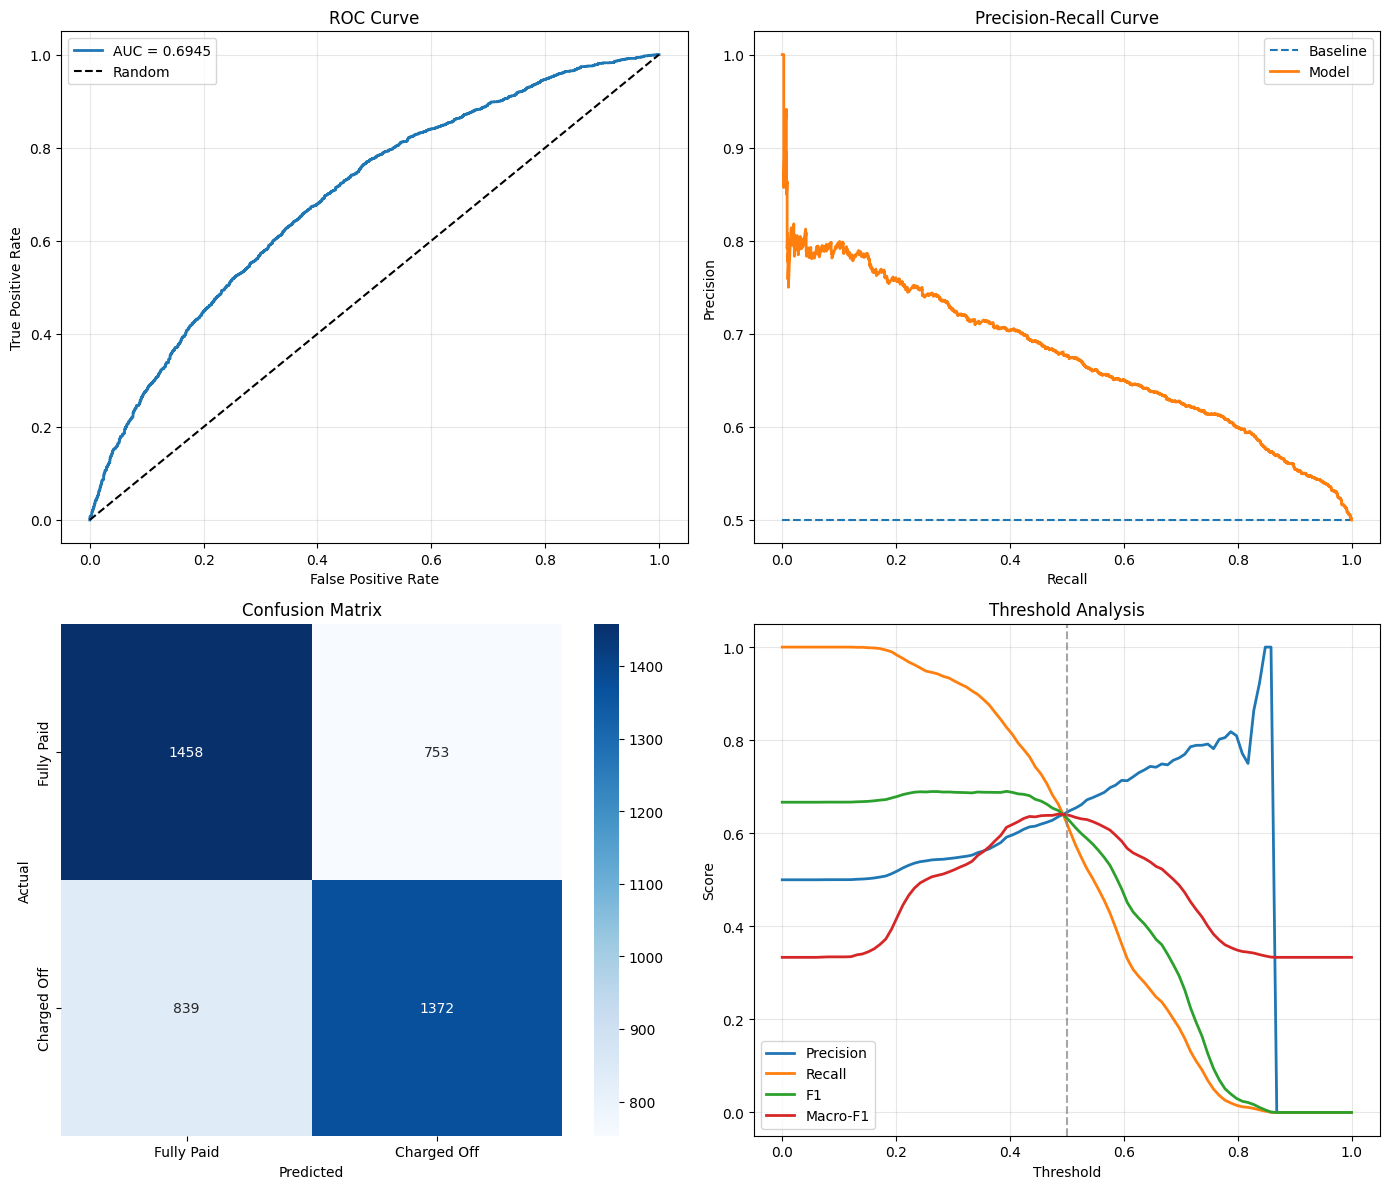

In [ ]:
# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc_score_val = auc(fpr, tpr)
axes[0, 0].plot(fpr, tpr, label=f'AUC = {roc_auc_score_val:.4f}', linewidth=2)
axes[0, 0].plot([0, 1], [0, 1], 'k--', label='Random')
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].set_title('ROC Curve')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
no_skill = len(y_test[y_test==1]) / len(y_test)
axes[0, 1].plot([0, 1], [no_skill, no_skill], linestyle='--', label='Baseline')
axes[0, 1].plot(recall, precision, label='Model', linewidth=2)
axes[0, 1].set_xlabel('Recall')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_title('Precision-Recall Curve')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0],
            xticklabels=['Fully Paid', 'Charged Off'],
            yticklabels=['Fully Paid', 'Charged Off'])
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Actual')
axes[1, 0].set_title('Confusion Matrix')

# Threshold Analysis
thresholds = np.linspace(0, 1, 100)
precision_scores = []
recall_scores = []
f1_scores = []
macro_f1_scores = []

for thresh in thresholds:
    y_pred_thresh = (y_pred_proba > thresh).astype(int)
    precision_scores.append(precision_score(y_test, y_pred_thresh, zero_division=0))
    recall_scores.append(recall_score(y_test, y_pred_thresh, zero_division=0))
    f1_scores.append(f1_score(y_test, y_pred_thresh, zero_division=0))
    macro_f1_scores.append(f1_score(y_test, y_pred_thresh, average='macro', zero_division=0))

axes[1, 1].plot(thresholds, precision_scores, label='Precision', linewidth=2)
axes[1, 1].plot(thresholds, recall_scores, label='Recall', linewidth=2)
axes[1, 1].plot(thresholds, f1_scores, label='F1', linewidth=2)
axes[1, 1].plot(thresholds, macro_f1_scores, label='Macro-F1', linewidth=2)
axes[1, 1].axvline(0.5, color='grey', linestyle='--', alpha=0.7)
axes[1, 1].set_xlabel('Threshold')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Threshold Analysis')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()